# High-Resolution DTM Analysis
### Demonstration Notebook
#### Author: Rafael Barbedo | Date: 2025-03-12

This notebook demonstrates basic terrain analysis using high-resolution Digital Terrain Models (DTMs). 
We will cover:
- Loading and visualizing a DTM.
- Computing and visualizing some terrain features:
    - **Slope** – Measures terrain steepness.
    - **Aspect** – Shows slope direction (north, south, etc.).
    - **Profile Curvature** – Controls water acceleration/deceleration.
    - **Plan Curvature** – Influences lateral water flow and erosion.


**Required Libraries:**
- `rasterio`
- `matplotlib`
- `whitebox`
- `numpy`
- `leafmap` (for interactive maps)

Let's get started!

In [29]:
# hold for installation

## **1 Define a Universal Raster Plotting Function**
To ensure consistency in visualizing raster outputs, we define a function that:
- **Loads and normalizes raster values.**
- **Displays georeferenced coordinates.**
- **Adds a histogram inset for value distribution.**

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import rasterio

def plot_raster(raster_path, label, color_scheme="terrain"):
    """
    Plots a raster with real-world coordinates, a colorbar, and a histogram inset.

    Parameters:
    - raster_path (str): Path to the raster file.
    - label (str): Label of the variable to show on the plot
    - color_scheme (str): Matplotlib colormap (default: "terrain").
    
    Returns:
    - Displays a plot with the raster, colorbar, and histogram.
    """

    # Load raster with rasterio to get georeferencing
    with rasterio.open(raster_path) as src:
        raster = src.read(1)  # Read the first band
        transform = src.transform  # Get the georeferencing transform
        bounds = src.bounds  # Get raster bounding box

    # Handle NoData values
    raster = np.where(raster == src.nodata, np.nan, raster)
    valid_data = raster[~np.isnan(raster)]

    # Compute Color Normalization
    datamin = np.percentile(valid_data, 2)
    datamax = np.percentile(valid_data, 98)
    norm = colors.Normalize(vmin=datamin, vmax=datamax)
    
    # Compute Real-World Extent
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]  # (minX, maxX, minY, maxY)

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Display the raster with real-world extent
    img = ax.imshow(raster, cmap=color_scheme, norm=norm, extent=extent, origin="upper")

    ax.set_xlabel("Easting (m)" if src.crs.is_projected else "Longitude (°)")
    ax.set_ylabel("Northing (m)" if src.crs.is_projected else "Latitude (°)")

    # Create a colorbar
    sm = cm.ScalarMappable(cmap=color_scheme, norm=norm)
    sm.set_array([])
    cax = ax.inset_axes([1.05, 0.35, 0.06, 0.5])  # Position the colorbar inset
    cbar = plt.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=8)
    cax.yaxis.set_ticks_position('right')
    cax.yaxis.set_label_position('right')

    # Histogram inset
    hax = ax.inset_axes([1.05, 0.05, 0.25, 0.25])
    colormap = plt.colormaps.get_cmap(color_scheme)

    # Filter raster values for histogram
    data = valid_data[(valid_data > datamin) & (valid_data < datamax)]

    # Plot % histogram
    n = len(data)
    _, bins, patches = hax.hist(data, bins=20, edgecolor='none', weights=np.ones(n)/n*100)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Normalize bin centers to [0, 1]
    col = (bin_centers - min(bin_centers)) / (max(bin_centers) - min(bin_centers))

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', colormap(c))

    hax.set_xlabel(label)
    hax.set_ylabel('Occupation (%)')
    hax.yaxis.set_ticks_position('right')
    hax.yaxis.set_label_position('right')

    plt.tight_layout()
    plt.show()


## Loading WhiteboxTools
We begin by importing `whitebox`, initializing the toolset.


In [ ]:
import whitebox

wbt = whitebox.WhiteboxTools()  # Create WhiteboxTools object
wbt.set_verbose_mode(False)  # Disable detailed logging

0

In [31]:
print(wbt.help())

WhiteboxTools Help

The following commands are recognized:
--cd, --wd          Changes the working directory; used in conjunction with --run flag.
--compress_rasters  Sets the compress_raster option in the settings.json file; determines if newly created rasters are compressed. e.g. --compress_rasters=true
-h, --help          Prints help information.
-l, --license       Prints the whitebox-tools license. Tool names may also be used, --license="Slope"
--listtools         Lists all available tools. Keywords may also be used, --listtools slope.
--max_procs         Sets the maximum number of processors used. -1 = all available processors. e.g. --max_procs=2
-r, --run           Runs a tool; used in conjunction with --wd flag; -r="LidarInfo".
--toolbox           Prints the toolbox associated with a tool; --toolbox=Slope.
--toolhelp          Prints the help associated with a tool; --toolhelp="LidarInfo".
--toolparameters    Prints the parameters (in json form) for a specific tool; --toolparame

In [32]:
wbt.list_tools(['DEM'])

{'aspect': 'Calculates an aspect raster from an input DEM.',
 'average_normal_vector_angular_deviation': 'Calculates the circular variance of aspect at a scale for a DEM.',
 'basins': 'Identifies drainage basins that drain to the DEM edge.',
 'breach_depressions': "Breaches all of the depressions in a DEM using Lindsay's (2016) algorithm. This should be preferred over depression filling in most cases.",
 'breach_depressions_least_cost': 'Breaches the depressions in a DEM using a least-cost pathway method.',
 'breach_single_cell_pits': 'Removes single-cell pits from an input DEM by breaching.',
 'circular_variance_of_aspect': 'Calculates the circular variance of aspect at a scale for a DEM.',
 'd8_flow_accumulation': 'Calculates a D8 flow accumulation raster from an input DEM or flow pointer.',
 'd8_pointer': 'Calculates a D8 flow pointer raster from an input DEM.',
 'd_inf_flow_accumulation': 'Calculates a D-infinity flow accumulation raster from an input DEM.',
 'd_inf_pointer': 'Calc

In [59]:
# Check WhiteboxTools version
print("WhiteboxTools Version:", wbt.version())

# Print the WhiteboxTools working directory
print("WhiteboxTools Directory:", wbt.work_dir)


WhiteboxTools Version: WhiteboxTools v2.4.0 (c) Dr. John Lindsay 2017-2023

WhiteboxTools is an advanced geospatial data analysis platform developed at
the University of Guelph's Geomorphometry and Hydrogeomatics Research 
Group (GHRG). See www.whiteboxgeo.com for more details.

WhiteboxTools Directory: /users/wrmod/rafbar/Projs/fdri-spatial-tools/data/processed


In [37]:
import os

data_dir = os.path.join(os.getcwd(), 'data/processed')
wbt.set_working_dir(data_dir)

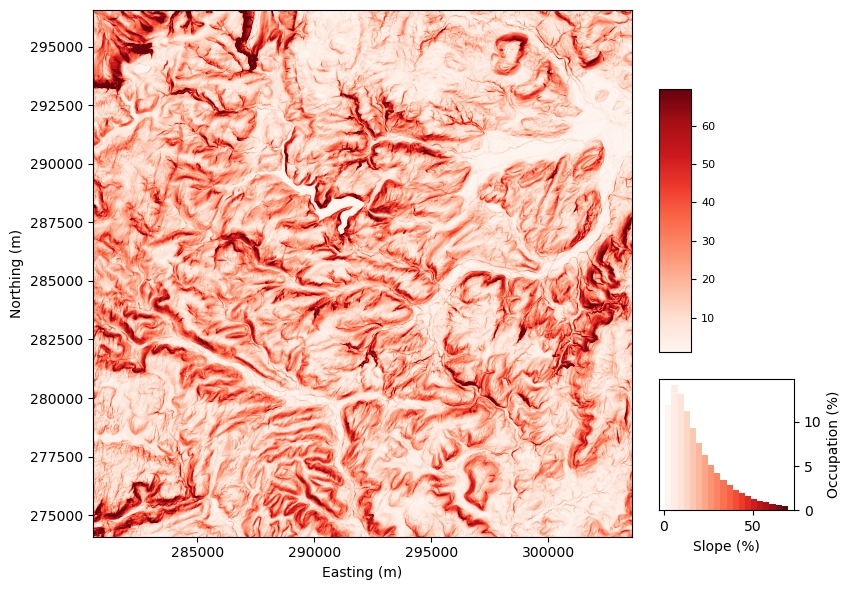

In [ ]:
wbt.slope(dem="dtm.tif", output="slope.tif", units="percent")
plot_raster(f"{data_dir}/slope.tif", label="Slope (%)", color_scheme="Reds")

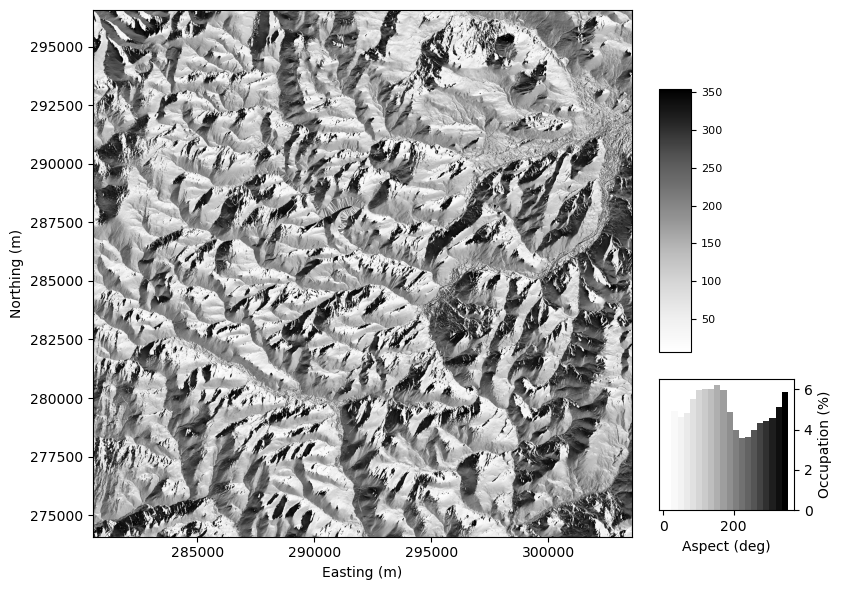

In [58]:
wbt.aspect(dem='dtm.tif', output="aspect.tif")
plot_raster(f"{data_dir}/aspect.tif", label="Aspect (deg)", color_scheme="Grays")

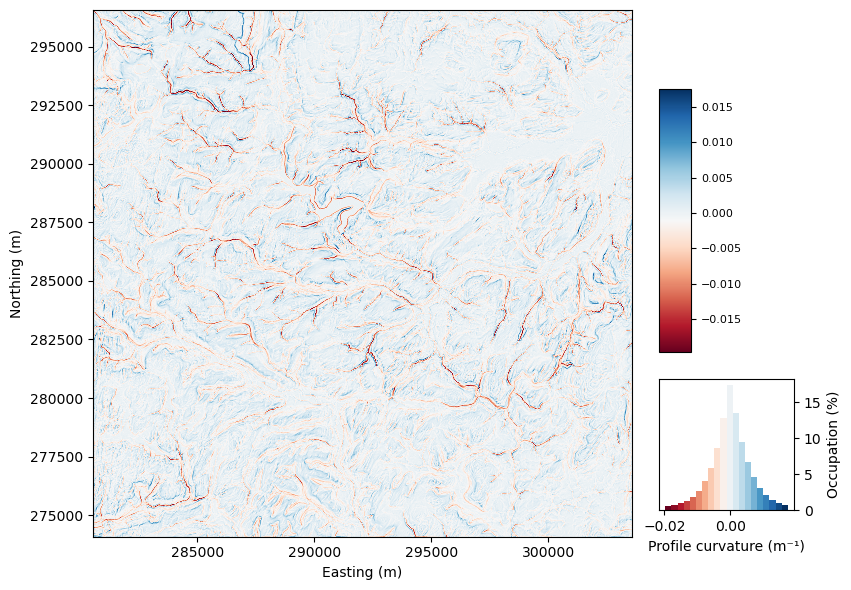

In [53]:
wbt.profile_curvature(dem='dtm.tif', output="profile_curv.tif")
plot_raster(f"{data_dir}/profile_curv.tif", label="Profile curvature (m⁻¹)", color_scheme="RdBu")

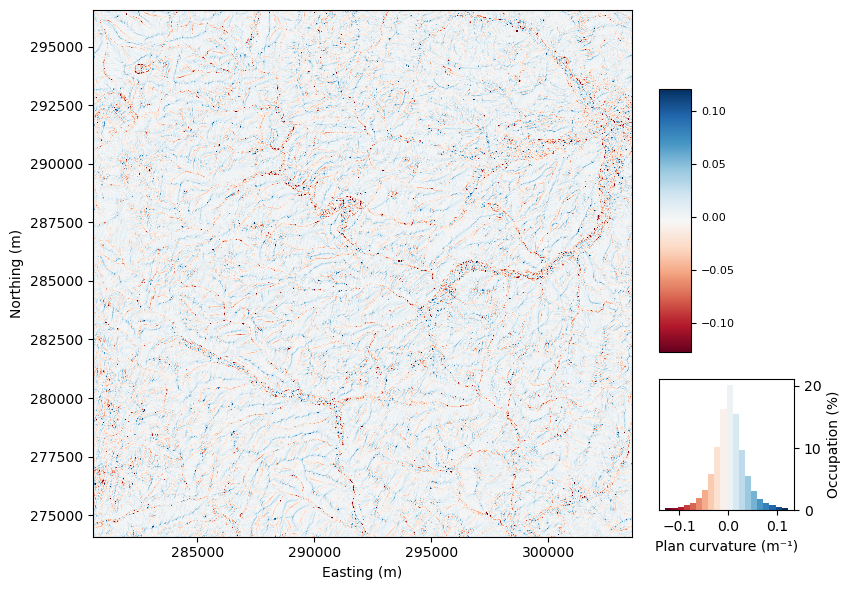

In [52]:
wbt.plan_curvature(dem='dtm.tif', output="plan_curv.tif")
plot_raster(f"{data_dir}/plan_curv.tif", label="Plan curvature (m⁻¹)", color_scheme="RdBu")